In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.hydrogenbonds as hba
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# Define initial variables
universe_file = 'FRAP-rap-rep1_500ns.part0003.gro'
trajectory_file = 'FRAP-rap_500_skip.xtc'

In [3]:
# Load the universe 
u = mda.Universe(universe_file, trajectory_file)

In [4]:
# Define the residue ranges for chain A and chain B
residues_chainA = range(1, 108)  # This includes residues 1 to 107
residues_chainB = range(2018, 2113)  # This includes residues 2018 to 2112

In [5]:
# Function to classify and count types of water bridges
def analysis(current, output, u):
    sele1_index, sele1_heavy_index, atom2, heavy_atom2, dist, angle = current[0]
    atom1, heavy_atom1, sele2_index, sele2_heavy_index, dist, angle = current[-1]
    sele1 = u.atoms[sele1_index]
    sele2 = u.atoms[sele2_index]
    (s1_resname, s1_resid, s1_name) = (sele1.resname, sele1.resid, sele1.name)
    (s2_resname, s2_resid, s2_name) = (sele2.resname, sele2.resid, sele2.name)
    if s2_resname == 'ARG' and s2_name in ('HH12', 'HH11', 'HH22', 'HH21'):
        s2_name = 'HH'
    key = (s1_resname, s1_resid, s1_name, s2_resname, s2_resid, s2_name)
    output[key] += 1

In [6]:
# DataFrame to store results
results = []

In [ ]:
# Iterate over each residue in chain A and chain B
for resA in residues_chainA:
    for resB in residues_chainB:
        # Define the water bridge analysis
        w = hba.WaterBridgeAnalysis(
            universe=u,
            selection1=f'resid {resA}',
            selection2=f'resid {resB}',
            water_selection='resname SOL',
            order=2,
            forcefield='other',
            donors=('NZ', 'NE', 'NH1', 'NH2', 'O','OH'),
            acceptors=('OD1', 'OD2', 'O','OH')
        )
        w.run()

        # Count water bridges by type
        new = w.count_by_type(analysis_func=analysis)

        # Prepare data for saving
        modified_data = []
        for (t, v) in new:
            if len(t) == 6:
                modified_data.append(((t[0], t[2], t[3], t[5]), v))

        df = pd.DataFrame(modified_data, columns=['tuple', 'value'])
        if not df.empty:
            df[['Res1', 'Atom1', 'Res2', 'Atom2']] = pd.DataFrame(df['tuple'].tolist(), index=df.index)
            df = df.drop(['tuple'], axis=1)
            df['Inhibitor'] = 1  # You can replace this with a variable if needed
            df['ResidueA'] = resA
            df['ResidueB'] = resB

            results.append(df)

In [10]:
# Concatenate all results into a single dataframe
final_df = pd.concat(results, ignore_index=True)

In [11]:
# Display the final DataFrame
print(final_df)

       value Res1 Atom1 Res2 Atom2  Inhibitor  ResidueA  ResidueB
0   0.011976  LYS     O  LYS   HZ3          1        35      2095
1   0.003992  LYS     O  LYS   HZ1          1        35      2095
2   0.009980  LYS     O  LYS   HZ2          1        35      2095
3   0.011976  PHE     O  LYS   HZ3          1        36      2095
4   0.017964  PHE     O  LYS   HZ2          1        36      2095
5   0.013972  PHE     O  LYS   HZ1          1        36      2095
6   0.001996  ASP   OD2  LYS   HZ1          1        37      2095
7   0.001996  ASP   OD1  LYS   HZ1          1        41      2095
8   0.001996  ASP   OD2  LYS   HZ1          1        41      2095
9   0.017964  ARG    HE  ASP   OD1          1        42      2102
10  0.007984  ARG  HH11  ASP   OD2          1        42      2102
11  0.153693  ARG  HH12  ASP   OD1          1        42      2102
12  0.145709  ARG  HH12  ASP   OD2          1        42      2102
13  0.149701  ARG  HH22  ASP   OD1          1        42      2102
14  0.1417

In [12]:
# Save to CSV
csv_file_path = 'water_bridges_all_residues.csv'
final_df.to_csv(csv_file_path, index=False)

In [16]:
# Filter DataFrame for value >= 0.2
filtered_df = final_df[final_df['value'] >= 0.2]

# Display the filtered DataFrame
print(filtered_df)

       value Res1 Atom1 Res2 Atom2  Inhibitor  ResidueA  ResidueB
28  0.331337  LYS     O  ARG    HH          1        47      2109
30  0.506986  TYR     O  ARG    HH          1        82      2042
33  0.764471  GLY     O  ARG    HH          1        86      2042
34  0.888224  GLY     O  ARG    HE          1        86      2042


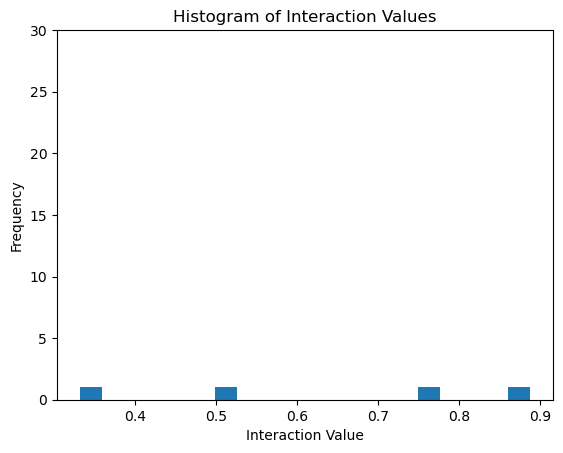

In [17]:
# VISUALIZATION
# Histogram of Interaction Values
plt.hist(filtered_df['value'], bins=20)
plt.title('Histogram of Interaction Values')
plt.xlabel('Interaction Value')
plt.ylabel('Frequency')
plt.ylim(top=6)
plt.show()

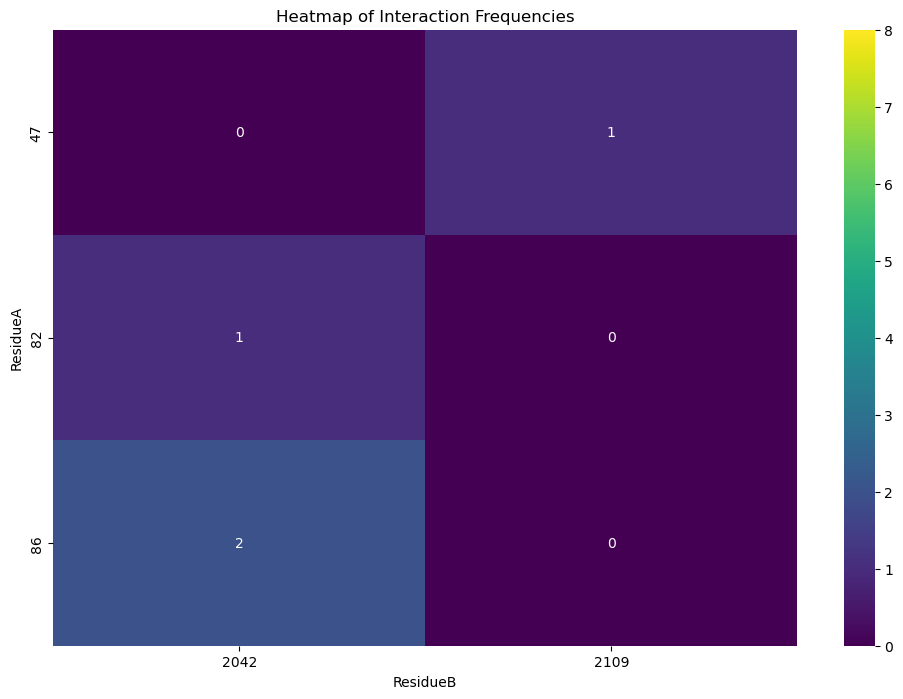

In [20]:
# VISUALIZATION
import seaborn as sns

# Heatmap for Interaction Frequencies
heatmap_data = filtered_df.pivot_table(index='ResidueA', columns='ResidueB', values='value', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', vmin=0, vmax=8)
plt.title('Heatmap of Interaction Frequencies')
plt.show()

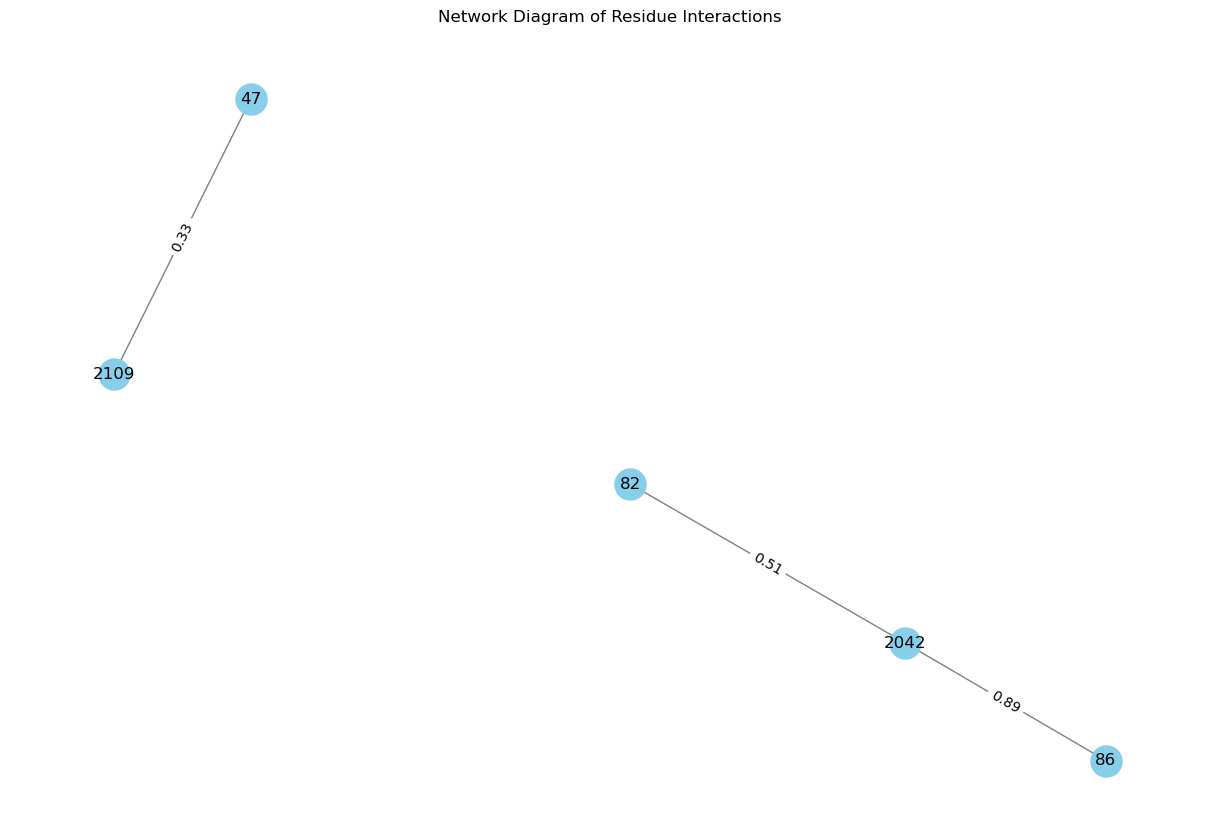

In [19]:
# VISUALIZATION
import networkx as nx

# Network Diagram of Interactions
G = nx.Graph()
for _, row in filtered_df.iterrows():
    G.add_edge(row['ResidueA'], row['ResidueB'], weight=row['value'])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)})
plt.title('Network Diagram of Residue Interactions')
plt.show()